In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
beijing_data = pd.read_csv('/content/drive/MyDrive/Dataset/beijing.csv')

# Print the shape and first 5 rows of the data
print("Data shape:", beijing_data.shape)
print(beijing_data.head())
# Check for missing values
print("Missing values:\n", beijing_data.isna().sum())


# use LOCF algorithm to fill missing stock prices
beijing_data.fillna(method='ffill', inplace=True)
print(beijing_data.head())

# Check for missing values in the imputed data
print("Missing values in imputed data:\n", beijing_data.isna().sum())

Data shape: (43824, 12)
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0  12.97   0   0
Missing values:
 No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
dtype: int64
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0  

In [8]:
# Create a new dataframe with only the 'pm2.5' column 
data = beijing_data.filter(['pm2.5'])
data=data.dropna()
# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .6 ))

window_size = 60
training_data_len

26280

In [9]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# create scaler
scaler = StandardScaler()
# fit and transform in one step
scaled_data = scaler.fit_transform(dataset)

print ('scaled_data.shape',len(scaled_data))
scaled_data

scaled_data.shape 43800


array([[ 0.34154088],
       [ 0.54942403],
       [ 0.66977743],
       ...,
       [-0.96046413],
       [-0.98234656],
       [-0.93858169]])

In [10]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len)]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    if i<= window_size + 1:
        print('x_train',x_train)
        print('\ny_train',y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print ('x_train.shape:',x_train.shape)

x_train [array([ 0.34154088,  0.54942403,  0.66977743,  0.91048424,  0.44001184,
        0.12271651,  0.07895163,  0.28683479,  0.24306991,  0.37436453,
        0.46189428,  0.5931889 ,  0.54942403,  0.72448353,  0.65883621,
        0.61507134,  0.66977743,  0.72448353,  0.79013084,  0.56036525,
        0.61507134,  0.72448353,  0.63695378,  0.30871722, -0.08516664,
       -0.38057955, -0.35869711, -0.46810929, -0.35869711, -0.16175517,
       -0.07422543, -0.12893152, -0.17269639, -0.12893152, -0.21646127,
        0.0023631 ,  0.10083407, -0.08516664, -0.01951933, -0.03046055,
       -0.12893152, -0.30399102, -0.40246198, -0.48999173, -0.2930498 ,
       -0.28210858, -0.2383437 , -0.27116736, -0.20552005, -0.43528564,
       -0.79634585, -0.78540463, -0.76352219, -0.78540463, -0.85105194,
       -0.75258097, -0.78540463, -0.77446341, -0.77446341, -0.79634585])]

y_train [-0.7525809749908796]

x_train [array([ 0.34154088,  0.54942403,  0.66977743,  0.91048424,  0.44001184,
        0.12

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

def build_LSTM_model():
    input = tf.keras.layers.Input(
        shape=(x_train.shape[1], 1), name ="input"
    )
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(25 , activation="relu", name ="dense_1")(x)
    
    output = tf.keras.layers.Dense(1, name="last_dense")(x)
               
    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_model = build_LSTM_model()
LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 60, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 60, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 25)                3225      
                                                                 
 last_dense (Dense)          (None, 1)                 26        
                                                                 
Total params: 300,723
Trainable params: 300,723
Non-trainable

In [12]:
epochs = 50
batch_size = 500
early_stopping_patience = 17


# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = LSTM_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
53/53 [==============================] - 18s 43ms/step - loss: 0.2206
Epoch 2/50
53/53 [==============================] - 2s 39ms/step - loss: 0.0935
Epoch 3/50
53/53 [==============================] - 2s 39ms/step - loss: 0.0823
Epoch 4/50
53/53 [==============================] - 2s 37ms/step - loss: 0.0788
Epoch 5/50
53/53 [==============================] - 2s 37ms/step - loss: 0.0745
Epoch 6/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0722
Epoch 7/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0713
Epoch 8/50
53/53 [==============================] - 2s 39ms/step - loss: 0.0704
Epoch 9/50
53/53 [==============================] - 2s 40ms/step - loss: 0.0688
Epoch 10/50
53/53 [==============================] - 2s 42ms/step - loss: 0.0689
Epoch 11/50
53/53 [==============================] - 2s 43ms/step - loss: 0.0682
Epoch 12/50
53/53 [==============================] - 2s 42ms/step - loss: 0.0669
Epoch 13/50
53/53 [=================

dict_keys(['loss'])


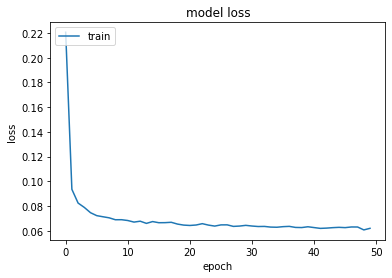

In [13]:
# list all data in history
print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - window_size: ]
print ('len(test_data):', len(test_data))

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = LSTM_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


len(test_data): 17580
548/548 [==============================] - 4s 5ms/step


<ipython-input-15-315574608bf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


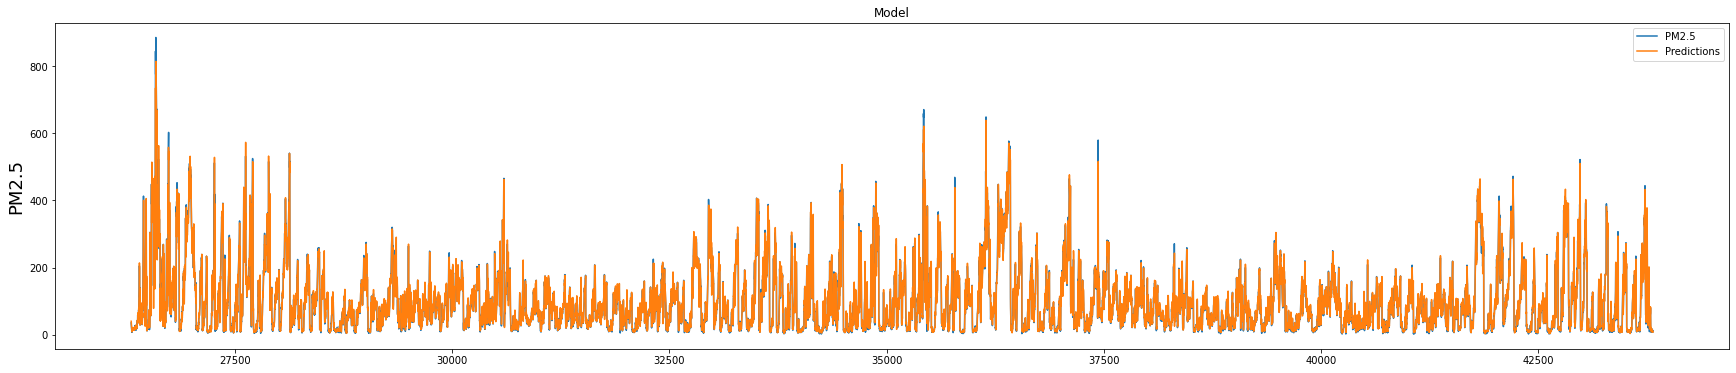

In [15]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(30,6))
plt.title('Model')
plt.ylabel('PM2.5', fontsize=18)
#plt.plot(train['Close'])
plt.plot(test[['pm2.5', 'Predictions']])
plt.legend(['PM2.5', 'Predictions'], loc='upper right')
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(test['Predictions'],y_test)
mse = mean_squared_error(test['Predictions'], y_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['Predictions'],y_test)
r = r2_score(test['Predictions'], y_test)

In [17]:
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Percentage Error:', mape)
print('R-Squared Score = {}'.format(r))

Mean Absolute Error: 12.332621518403428
Mean Squared Error: 535.5310309340342
Root Mean Squared Error: 23.141543399998934
Mean Absolute Percentage Error: 0.1777881558335064
R-Squared Score = 0.939346336101097
